# Trabalho 4 - Operações Geométricas

## Scanner doméstico usando um celular.

Os filhos do professor de visão computacional são aficionados por Star Wars. O maiorzinho queria uma imagem de um storm trooper como plano de fundo para o seu tablet. Contudo, o scanner de casa está quebrado e o salário do professor está muito atrasado. O pior é que o governador Pezão nem sequer diz quando vai pagar os três salário em atraso. Como a grana está curta, o professor resolveu usar câmera do celular. No entanto, é sabido que a imagem obtida pela câmera impõe à imagem original uma geometria projetiva e esta distorção precisa ser compensada já que o garoto ficou muito triste com a qualidade do resultado obtido pela câmera. Felizmente, como o pai dos meninos é professor, ele propôs que seus alunos da Uerj resolvessem este problema como trabalho para a disciplina. Para facilitar a tarefa, o professor fotografou a imagem do storm trooper sobre uma folha de papel A4 que serve como referência. Obtenha a transformação projetiva que recupere a geometria da imagem original e reconstrua-a usando a interpolação bilinear. Veja a seguir a imagem de entrada.

Faça toda a álgebra linear manualmente, das bibliotecas usadas no curso, você só pode usar as funções  ```imread``` e ```imwrite```.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance as dist

In [2]:
np.set_printoptions(threshold = np.nan)

-------

#### Definição de Funções

In [3]:
def img2binary(img, threshold = 60):
    """Binarization of image with threshold given"""
    return threshold < img

In [4]:
def roberts(img):
    """Apply Roberts filter to image"""
    k_robertsx = np.array([[1, 0], [0, -1]])
    k_robertsy = np.array([[0, 1], [-1, 0]])
    robertsx = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsx, -1)))
    robertsy = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsy, -1)))
    
    return robertsx + robertsy

In [5]:
def binary_roberts(img, threshold = 60):
    """Returns roberts image in binary scale"""
    return img2binary(roberts(img), threshold).astype(np.uint8)

In [74]:
def clockwise_sort(corners):
    x_sorted = corners[np.argsort(corners[:, 0]), :]
    
    left_corners = x_sorted[:2, :]
    right_corners = x_sorted[2:, :]
    
    top_left, bottom_left = left_corners[np.argsort(left_corners[:, 1]), :]
    
    d = dist.cdist(top_left[np.newaxis], right_corners, 'euclidean')[0]
    bottom_right, top_right = right_corners[np.argsort(d)[::-1], :]
    
    return np.array([top_left, top_right, bottom_right, bottom_left], dtype = np.int)

In [7]:
def detect_corners(img):
    """Detect corners based on non zero pixel of image object borders"""
    b = np.where(img > 0)
    p1 = np.array([b[0][np.argmin(b[0])], b[1][np.argmin(b[0])]])
    p2 = np.array([b[0][np.argmax(b[1])], b[1][np.argmax(b[1])]])
    p3 = np.array([b[0][np.argmax(b[0])], b[1][np.argmax(b[0])]])
    p4 = np.array([b[0][np.argmin(b[1])], b[1][np.argmin(b[1])]])
    p5 = np.array([b[1].min(), b[0].min()])
    p6 = np.array([b[1].min(), b[0].max()])
    p7 = np.array([b[1].max(), b[0].max()])
    p8 = np.array([b[1].max(), b[0].min()])
    
    corners = np.array([p1, p2, p3, p4, p5, p6, p7, p8])
    
    return np.unique(corners[img[corners[:,0], corners[:,1]] == 1], axis = 0)

In [8]:
def cornerfy_from_file(filein, fileout = ''):
    imgin = cv.imread(filein, 0)
    roberts_binary = binary_roberts(imgin)
    corners = detect_corners(roberts_binary)
#     save_image_with_corners(imgin, corners, fileout)
    return roberts_binary, clockwise_sort(corners)

In [9]:
def cornerfy_from_array(arrayin, fileout = ''):
    roberts_binary = binary_roberts(arrayin)
    corners = detect_corners(roberts_binary)
#     save_image_with_corners(arrayin, corners, fileout)
    return roberts_binary, clockwise_sort(corners)

In [10]:
def true_corners(img, corners):
    for i in range(len(corners)):
        if img[tuple(corners[i])] == 0:
            ind = tuple(corners[i])
            idx = np.argwhere(img)
            idx = idx[~(idx == ind).all(1)]
            corners[i] = idx[((idx - ind)**2).sum(1).argmin()]
    
    return clockwise_sort(corners)

In [11]:
def transformation_coefficients(img_in, img_out):
    A = np.zeros

-------

## Figuras/Imagens

Lê a figura do Stormtrooper

In [12]:
stormtrooper = cv.imread('../images/IMG_20170615_082455.jpg', 0)

Cria o painel do A4 em branco (sem intensidade nos pixels)

In [13]:
# A4 para 150 ppi
# A4 totalmente branco
A4 = np.zeros((1754, 1240), dtype = np.uint8)

Cria um losango

In [14]:
diamond = np.uint8([[(30 <= x + y) & (10 >= -x + y) & (-10 <= -x + y) & (50 >= x + y) for y in range(41)] for x in range(41)]) * 255

Cria um quadrado

In [15]:
square = np.uint8([[(x >= 10) & (x <= 30) & (y >= 10) & (y <= 30) for y in range(41)] for x in range(41)]) * 255

------

## Teste da Identificação dos Cantos

Usando as imagens do losango e do quadrado vamos testar o algoritmo para identificar os cantos da imagem.

In [75]:
diamond_roberts, diamond_corners = cornerfy_from_array(diamond)
diamond_corners = true_corners(diamond, diamond_corners)

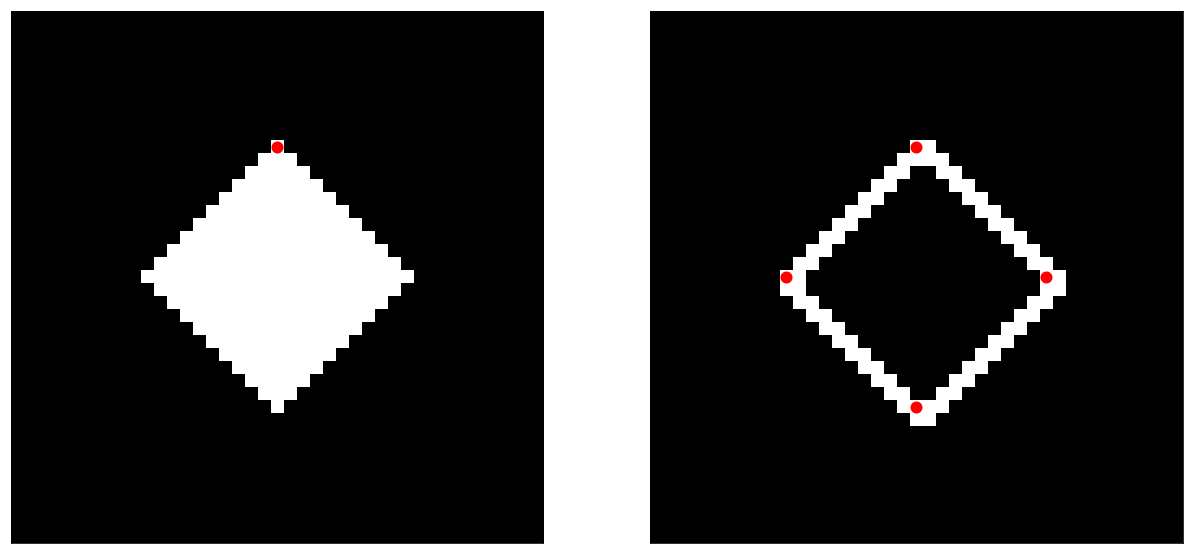

In [76]:
fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(diamond, cmap = 'gray')
ax.scatter(diamond_corners[3,1], diamond_corners[3,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(diamond_roberts, cmap = 'gray')
ax.scatter(diamond_corners[:,1], diamond_corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])

plt.show()

In [77]:
square_roberts, square_corners = cornerfy_from_array(square)
square_corners = true_corners(square, square_corners)

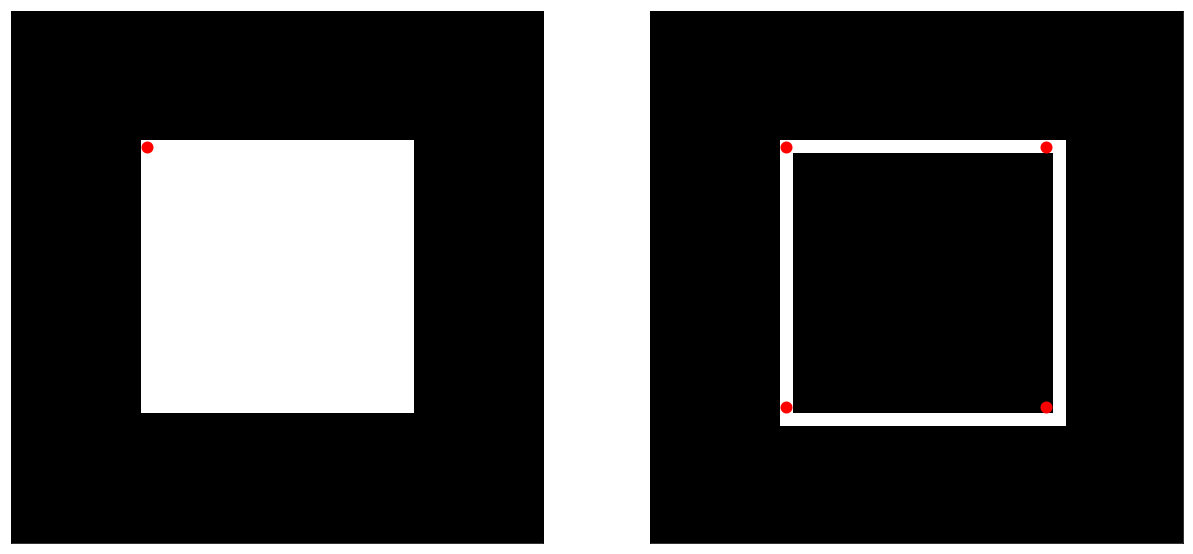

In [78]:
fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(square, cmap = 'gray')
ax.scatter(square_corners[0,1], square_corners[0,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(square_roberts, cmap = 'gray')
ax.scatter(square_corners[:,1], square_corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])
plt.show()

plt.show()

In [79]:
stormtrooper_roberts, stormtrooper_corners = cornerfy_from_array(stormtrooper)
stormtrooper_corners = true_corners(stormtrooper, stormtrooper_corners)

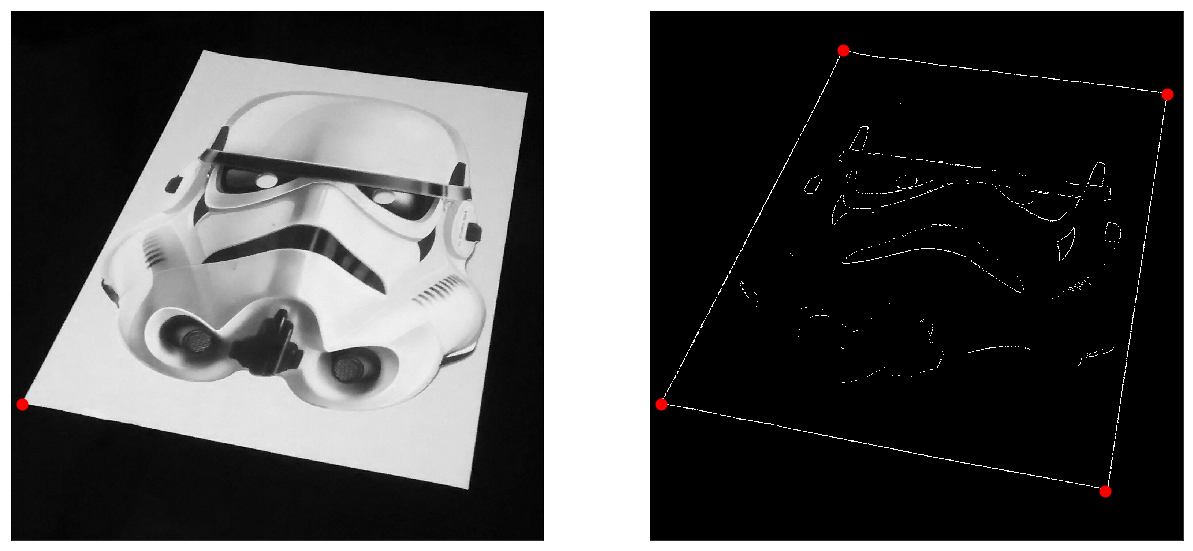

In [82]:
fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(stormtrooper, cmap = 'gray')
ax.scatter(stormtrooper_corners[1,1], stormtrooper_corners[1,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(stormtrooper_roberts, cmap = 'gray')
ax.scatter(stormtrooper_corners[:,1], stormtrooper_corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])
plt.show()

plt.show()

In [22]:
stormtrooper_corners

array([[ 107,  527],
       [1076,   31],
       [1312, 1245],
       [ 227, 1412]])

In [51]:
A4_corners = np.array([[0,0], [0, 1240], [1754, 0], [1754, 1240]])
A4_corners = clockwise_sort(A4_corners)

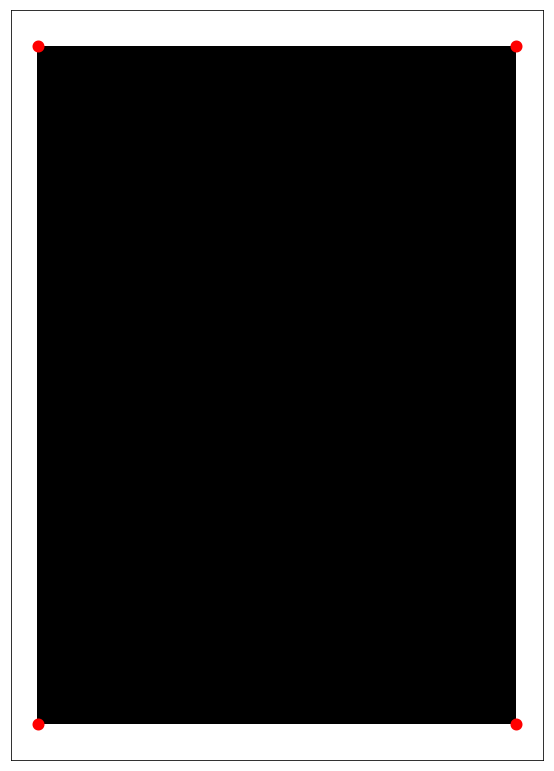

In [56]:
fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(A4, cmap = 'gray')
ax.scatter(A4_corners[:,1], A4_corners[:,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])


plt.show()

In [57]:
stormtrooper_corners

array([[ 107,  527],
       [1076,   31],
       [1312, 1245],
       [ 227, 1412]])

In [150]:
corners = stormtrooper_corners

In [116]:
x_sorted = corners[np.argsort(corners[:, 0]), :]
    

top_left = x_sorted[0]
left_corners = x_sorted[:2, :]
right_corners = x_sorted[2:, :]
    
top_left, bottom_left = left_corners[np.argsort(left_corners[:, 1]), :]
    
d = dist.cdist(top_left[np.newaxis], right_corners, 'euclidean')[0]
bottom_right, top_right = right_corners[np.argsort(d)[::-1], :]
    
np.array([top_left, top_right, bottom_right, bottom_left], dtype = np.int)

array([[ 107,  527],
       [1076,   31],
       [1312, 1245],
       [ 227, 1412]])

In [118]:
left_corners[np.argsort(left_corners[:, 1]), :]

array([[ 107,  527],
       [ 227, 1412]])

In [122]:
right_corners

array([[1076,   31],
       [1312, 1245]])

In [121]:
top_left[np.newaxis]

array([[107, 527]])

In [120]:
left_corners[1]

array([ 227, 1412])

In [95]:
corners

array([[ 107,  527],
       [1076,   31],
       [1312, 1245],
       [ 227, 1412]])

In [96]:
x_sorted

array([[ 107,  527],
       [ 227, 1412],
       [1076,   31],
       [1312, 1245]])

In [97]:
left_corners

array([[ 107,  527],
       [ 227, 1412]])

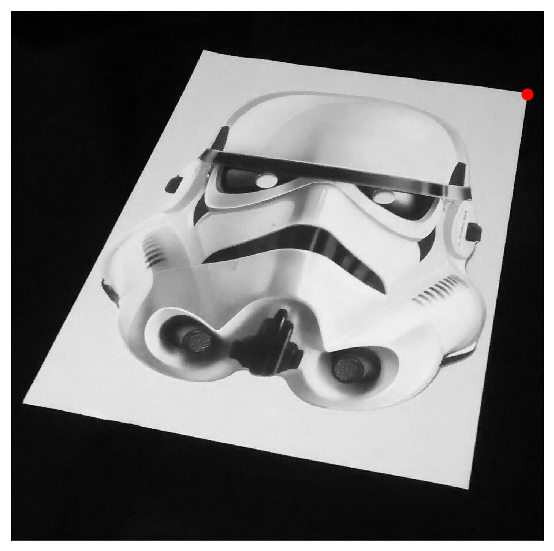

In [119]:
fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(stormtrooper, cmap = 'gray')
ax.scatter(left_corners[1,1], left_corners[1,0], marker = 'o', color = 'red', linewidths = 6)
plt.xticks([])
plt.yticks([])


plt.show()

In [106]:
rect = np.zeros((4, 2), dtype = np.int)
 
s = corners.sum(axis=1)
rect[0] = corners[np.argmin(s)]
rect[2] = corners[np.argmax(s)]
 
diff = np.diff(corners, axis = 1)
rect[1] = corners[np.argmin(diff)]
rect[3] = corners[np.argmax(diff)]

In [107]:
rect

array([[ 107,  527],
       [1076,   31],
       [1312, 1245],
       [ 227, 1412]])

In [127]:
top_left = corners[np.argsort(corners[:, 0]), :][0]

In [138]:
corners[np.argsort(corners[:, 0]), :]

TypeError: only integer scalar arrays can be converted to a scalar index

In [151]:
corners

array([[ 107,  527],
       [1076,   31],
       [1312, 1245],
       [ 227, 1412]])

In [139]:
np.argsort(corners[:, 0])

array([0, 3, 1, 2])

In [160]:
corners = corners[(corners != top_left)[:, 0]]

In [164]:
bottom_left = corners[np.argsort(corners[:, 1]), :][0]

In [165]:
corners = corners[(corners != bottom_left)[:, 0]]

In [166]:
corners

array([[1312, 1245],
       [ 227, 1412]])